# Statistikos departamento užduotis pt. Pandas

## Packages and Data import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.offline as pyo
import plotly.graph_objects as go


In [2]:
df = pd.read_csv("AtvejaiPagalDarbovietes.csv")
cols = ['apskritis','jau_tirta_nvsc', 'darbuotojai', 'atvejai_viso', 'atvejai_14d',
       'norma_14d', 'testai_14d','aliarmas', 'imones_pavadinimas', 'veiklos_pobudis']
df = df[cols]

In [3]:
# veiklos pobudis ir atvejai viso
duomenai = pd.DataFrame(df[['veiklos_pobudis','darbuotojai','atvejai_viso']].groupby('veiklos_pobudis').sum())
duomenai.reset_index(inplace=True)
duomenai['atv_per_dv'] = duomenai['darbuotojai']/duomenai['atvejai_viso']

In [4]:
# grouping based on company size
bins = pd.IntervalIndex.from_tuples([(0, 100), (100, 300), (300, 1000),(1000,100000)])
names=["Maza", "Vidutine", "Didele","Super"]

to_name = {bin: name for bin, name in zip(bins, names)}

named_series = pd.Series(pd.CategoricalIndex(pd.cut(duomenai['darbuotojai'], bins)).rename_categories(to_name))
duomenai['Dydis'] = named_series

### _`Matplot`_ visual

In [5]:
def graph_histo(x):
    if x.dtype == "int64" or x.dtype == "float64":
        size_bins = 10
        title = "Size relevant distribution"
        #Assign random colors to each graph
        color_kde = list(map(float, np.random.rand(3,)))
        sns.histplot(x, bins=size_bins,kde=True,color =color_kde)
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.ylabel("Frequency", size=12, labelpad=13);
        plt.title(title, size=15)
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False); 
    else:
        x = pd.DataFrame(x) 
        sns.catplot(x=x.columns[0], kind="count", palette="spring", data=x)
        title = x.columns[0]
        plt.title(title, size=18)
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.xlabel("")
        plt.ylabel("Counts", size=16, labelpad=15);        
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);

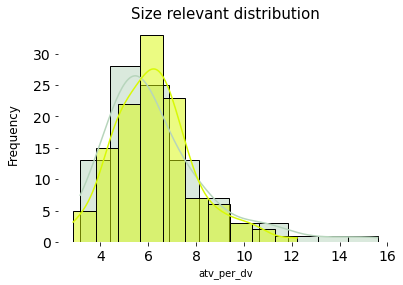

In [6]:
graph_histo(duomenai[duomenai["Dydis"]=='Vidutine']['atv_per_dv'])
graph_histo(duomenai[duomenai["Dydis"]=='Super']['atv_per_dv'])

### Lietuvos ir savivaldybių palyginimas naudojant _`Plotly`_

In [7]:
# general statistics of the country
df = pd.read_csv("SvieslenciuStatistika.csv")
pokyciai = ['ab_prc_day', 'ag_prc_day','date', 'dgn_prc_day', 'pcr_prc_day','municipality_name']
df = df[pokyciai]

In [8]:
# kad nebut šališku, renkuos random savivalda ir diena
savivalda = random.choice(df['municipality_name'].unique())
day = random.choice(df['date'].unique())

In [9]:
def data_prep(day, savivalda):
    lt_stats = df[df['municipality_name'] == 'Lietuva'].copy()
    select_region = df[df['municipality_name'] == savivalda].copy()
    chose_a_day = lt_stats[lt_stats['date'] == day ]
    chosen_day = select_region[select_region['date'] == day ]
    lt_vs_rajon = pd.DataFrame(pd.concat([chose_a_day,chosen_day]).drop('date',axis = 1)\
        .set_index('municipality_name').transpose())
    return lt_vs_rajon

In [10]:
lt_vs_rajon = data_prep(day, savivalda)

In [11]:
my_range = range(1,5)
data1 = go.Scatter(
        x=lt_vs_rajon['Lietuva'],
        y=np.array(my_range),
        mode='markers',
        marker=dict(color='#003953'),
        name = 'Lietuvos pokytis',
        text=lt_vs_rajon.index,
        #animation_frame=1,
        
    )

data2 = go.Scatter(
        x=lt_vs_rajon[savivalda],
        y=np.array(my_range),
        mode='markers',
        #marker=dict(color='#0096d7'),
        marker=dict(color='red'),
        name = savivalda,
        text=lt_vs_rajon.index,
        #animation_frame=1,
       
    )

#Horizontal line shape
shapes=[dict(
        type='line',
        x0 = lt_vs_rajon['Lietuva'].iloc[i],
        y0 = i + 1,
        x1 = lt_vs_rajon[savivalda].iloc[i],
        y1 = i + 1,
        line = dict(
            color = 'grey',
            width = 2
        )
     ) for i in range(len(lt_vs_rajon['Lietuva']))]

layout = go.Layout(
    shapes = shapes,
    title='Dienos pokytis lyginant ' + savivalda+' su Šalimi',
    paper_bgcolor='#ADD8E6',
    plot_bgcolor='#ADD8E6',
        )




# Plot the chart
fig = go.Figure([data1, data2], layout)

fig.update_layout(
    xaxis = dict(showgrid= False,
        zeroline= False,
        ticktext = lt_vs_rajon.index
    ))
fig.update_yaxes(showticklabels=False)
fig.show()

Ir tada, ieškodamas idėjų ką dar galėčiau vizualizuoti, supratau, jog jei bandysiu atkurti kažkieno kito darbą - nieko nebus. Sukursiu kažką savo.

## LSTM Implementation

In [12]:
LT_data = pd.read_csv('AtvejaiIrMirtys.csv')
LT_data = LT_data[['municipality_name', 'date', 'sex','age_gr', 'new_cases', 'deaths_all', 'deaths_cov1', 'deaths_cov2', 'deaths_cov3']]
LT_data

,municipality_name,date,sex,age_gr,new_cases,deaths_all,deaths_cov1,deaths_cov2,deaths_cov3
0,Vilniaus m. sav.,2021-09-25,Moteris,20-29,20,0,0,0,0
1,Vilniaus m. sav.,2021-09-25,Moteris,50-59,20,0,0,0,0
2,Vilniaus m. sav.,2021-09-25,Moteris,60-69,19,0,0,0,0
3,Vilniaus m. sav.,2021-09-25,Moteris,70-79,7,0,0,0,0
4,Vilniaus m. sav.,2021-09-25,Moteris,80-89,5,1,1,1,1
...,...,...,...,...,...,...,...,...,...
156514,Lazdijų r. sav.,2021-09-29,Vyras,10-19,2,0,0,0,0
156515,Marijampolės sav.,2021-09-29,Vyras,30-39,1,0,0,0,0
156516,Mažeikių r. sav.,2021-09-29,Moteris,10-19,1,0,0,0,0
156517,Pagėgių sav.,2021-09-29,Vyras,10-19,2,0,0,0,0


In [13]:
tst = LT_data[['municipality_name','date','new_cases']].copy()
tst = tst.groupby(['municipality_name','date']).sum().sort_values(by='date').reset_index()
tst.date = pd.to_datetime(tst.date)
tst

,municipality_name,date,new_cases
0,Akmenės r. sav.,2020-02-01,0
1,Pakruojo r. sav.,2020-02-01,0
2,Lazdijų r. sav.,2020-02-01,0
3,Rokiškio r. sav.,2020-02-01,0
4,Kelmės r. sav.,2020-02-01,0
...,...,...,...
30284,Klaipėdos m. sav.,2021-09-29,181
30285,Šiaulių m. sav.,2021-09-29,62
30286,Kelmės r. sav.,2021-09-29,22
30287,Palangos m. sav.,2021-09-29,14


In [15]:
tst = tst.groupby('date').sum()[50:] #.reset_index() # nepaisau pirmu dienu (kenkia modeliui)

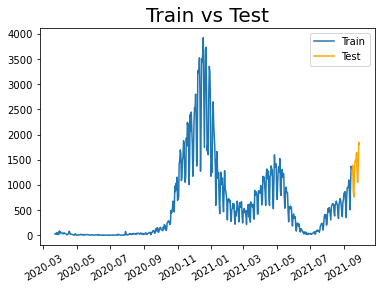

In [16]:
test_size = 14 #2 savaites

df_train = tst[:-test_size]
df_test = tst[-test_size:]

plt.title('Train vs Test', size=20)
plt.plot(df_train['new_cases'], label='Train')
plt.xticks(rotation=30)
plt.plot(df_test['new_cases'], label='Test', color='orange')
plt.legend();

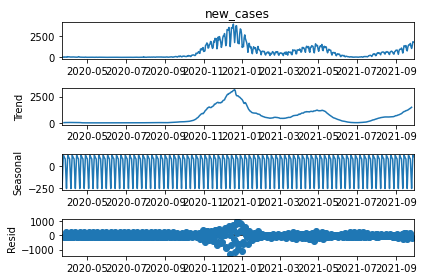

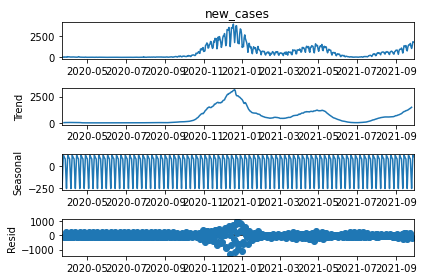

In [17]:
tst.index.freq = 'D'
results = seasonal_decompose(tst['new_cases'])
results.plot()

In [18]:
# normalizuokime
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.advanced_activations import LeakyReLU
#https://stackoverflow.com/questions/58276337/proper-way-to-feed-time-series-data-to-stateful-lstm/58277760#58277760

In [20]:
n_input = 13 
n_features = 1 
generator = TimeseriesGenerator(scaled_train, scaled_train, length= n_input, batch_size=n_features)

In [21]:
# kas bus ryt jei zinau praeitas dvi savaites
X,y = generator[0]
print(f'Imput array: \n{X.flatten()}')
print(f'Expected prediction: \n {y}')

Imput array: 
[0.00687548 0.00763942 0.00585689 0.01375095 0.00407436 0.01120448
 0.00891266 0.004329   0.02189967 0.00993125 0.01757066 0.0145149
 0.01298701]
Expected prediction: 
 [[0.00993125]]


### Unidirectional LSTM

In [22]:
model = Sequential()

model.add(LSTM(128, activation='relu', input_shape=(n_input, n_features)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1)) 
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam')


In [23]:
model.fit(generator, validation_data=generator, epochs=200)

Epoch 1/200
530/530 [==============================] - 8s 10ms/step - loss: 0.0172 - val_loss: 0.0101
Epoch 2/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 3/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 4/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 5/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0061 - val_loss: 0.0136
Epoch 6/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 7/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 8/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 9/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 10/200
530/530 [==============================] - 2s 4ms/step - loss: 0.0060 - val_l

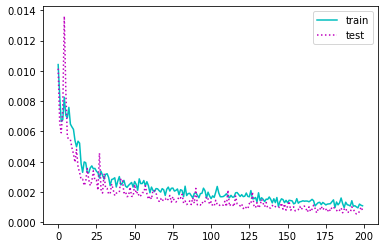

In [24]:
plt.plot(model.history.history['loss'], 'c-', label='train')
plt.plot(model.history.history['val_loss'], 'm:', label='test')
plt.legend()

In [25]:
test_preds = []
first_batch = scaled_train[-n_input:]
curr_batch = first_batch.reshape((1, n_input, n_features))
for i in range(len(df_test)):
    curr_pred = model.predict(curr_batch)[0]
    test_preds.append(curr_pred)

    curr_batch = np.append(curr_batch[:,1:,:],[[curr_pred]], axis=1)

In [26]:
true_predictions = scaler.inverse_transform(test_preds)

In [27]:
df_test['Prediction'] = true_predictions

<ipython-input-27-dedd2e8d0fe6>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
df_test

,new_cases,Prediction
date,,
2021-09-16,1250,1302.479856
2021-09-17,1391,1234.343410
2021-09-18,878,890.564816
2021-09-19,762,661.496237
2021-09-20,1192,1170.314379
2021-09-21,1431,1355.711474
2021-09-22,1499,1339.770077
2021-09-23,1465,1283.059281
2021-09-24,1641,1167.159735


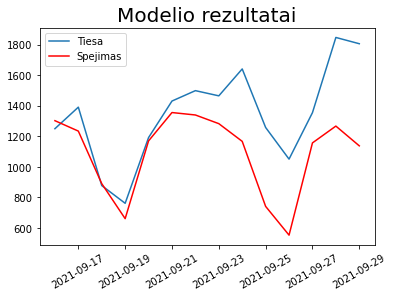

In [29]:
plt.title('Modelio rezultatai', size=20)
plt.xticks(rotation=30)
plt.plot(df_test['new_cases'], label='Tiesa')
plt.plot(df_test['Prediction'], label='Spejimas', color='red')
plt.legend();